In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bootstrap import bootstrap
from scipy.stats import chi2_contingency

# SQL tasks
import pandahouse as ph

# Data import module
from get_data import get_data_ya_disk

# Настройки по умолчанию

In [2]:
default_viz = {'figure.titlesize': 20, 'legend.fontsize': 16, 'legend.title_fontsize': 16,
               'axes.titlesize': 20, 'axes.labelsize': 12, 'axes.titlepad': 18,                
              }

# Установим тему для графиков по-умолчанию
sns.set_theme(style="whitegrid", palette="rocket", rc=default_viz)

# Задание 1. A/B–тестирование

### В качестве входных данных имеется 4 csv-файла:  
**groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)  
**groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
**active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.  
**checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### Импорт данных

In [3]:
help(get_data_ya_disk)

Help on function get_data_ya_disk in module get_data:

get_data_ya_disk(data_keys)
    Params:
        - list of public urls to ya disk files        
    Return:
        - list of download urls



In [4]:
# Ссылки на файлы данных
data_keys = ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', 
             'https://disk.yandex.ru/d/3aARY-P9pfaksg',
             'https://disk.yandex.ru/d/prbgU-rZpiXVYg',
             'https://disk.yandex.ru/d/84hTmELphW2sqQ'] 

# Получим список url для загрузки
download_urls = get_data_ya_disk(data_keys)

In [5]:
# Загрузим данные в датафреймы
groups       = pd.read_csv(download_urls[0], sep=';')
groups_add   = pd.read_csv(download_urls[1])
active_studs = pd.read_csv(download_urls[2])
checks       = pd.read_csv(download_urls[3], sep=';')

***Ремарка***  
В данных использованы разные разделители, стоит обратить внимание инженеров

### Предобработка данных

По описанию не очень ясно, что значит "2 дня после передачи данных".  
Условимся, что файл с доп пользователями прислали до эксперимента.  
Соответственно добавим их к общему списку.

In [6]:
groups = pd.concat([groups, groups_add], ignore_index=True)

In [7]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [9]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


В данных нет пропущенных значений.  
Сами данные достаточно "консервативные", имеем только распределение пользователей по группам, трафик и чеки в процессе экспремента.  
Никаких временных данных о длительности эксперимента, локации пользователя или другой общей информации

Посмотрим на распределение пользователей по группам

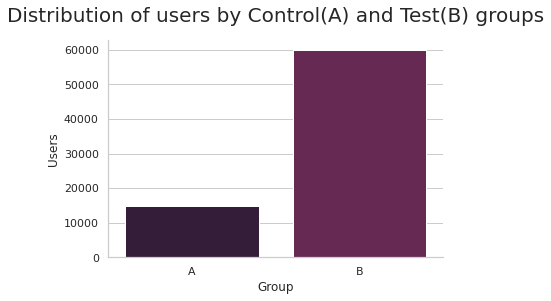

In [10]:
ab_distribution = groups.groupby('grp', as_index=False).agg(total=('id', 'count'))

sns.barplot(data=ab_distribution, x='grp', y='total')

plt.xlabel('Group')
plt.ylabel('Users')
plt.title('Distribution of users by Control(A) and Test(B) groups')

sns.despine()
plt.show()

In [11]:
ab_distribution

,grp,total
0,A,14693
1,B,59883


Посмотрим на данные о покупках

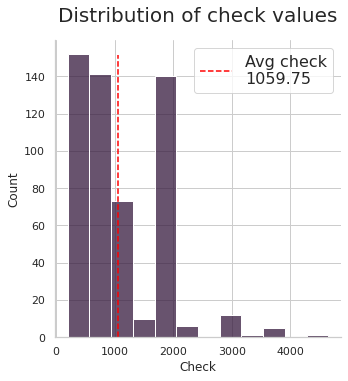

In [12]:
# Посчитаем средний чек
avg_check = np.round(checks.rev.mean(), 2)

# Визуализируем для быстрой оценки
sns.displot(checks.rev)

plt.xlabel('Check')
plt.title('Distribution of check values')
plt.axvline(x=avg_check, 
            ymin=0, 
            ymax=0.95, 
            color='red',
            linestyle='--',
            label='Avg check\n' + str(avg_check)
           )

sns.despine()
plt.legend()
plt.show()

Ожидаемо видим, что большее количество пользователей имеет чек ниже среднего.  
Однако, есть значительный "выброс" в районе 2000.  
Посмотрим внимательнее.

In [13]:
checks.rev.value_counts().head(10)

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
Name: rev, dtype: int64

При более детальном рассмотрении, видим, что:
1. Количество пользователей с чеком 1900 - преобладает
2. Более того, есть значительная группа пользователей с чеком 1900.0001  

***Вывод 1***  
В датафрейме checks в колонке rev, имеем чек каждого пользователя, соответственно разговор о деньгах.
В фин. учете действительно часто используется система записи с 4-мя десятичными знаками, однако это не имеет смысла для учета чеков пользователей.  
Скорее всего, это ошибка при сборе данных.  
Округлим до 2-х знаков после запятой, тогда группа пользователей с чеком 1900.0000 сольется с группой 1900.0001 

***Вывод 2***  
Такой выброс в среднем чеке не характерен, возможные причины:
1. У нас есть супер популярный товар, который все покупают, с ценой 1900.
2. Ошибка при сборе данных.  

Поскольку в задаче нет никаких вводных о структуре сайта или товарах, однозначные выводы сделать сложно

In [14]:
# Округлим чеки
checks.rev = np.round(checks.rev, 2)

Посмотрим к какой группе относятся пользователи с чеком 1900  
Для этого к датафрейму checks добавим данные о принадлежности к А/В из groups

In [15]:
ab_checks = checks.merge(groups, left_on='student_id', right_on='id', how='left')
ab_checks.drop(columns='student_id', inplace=True)

In [16]:
# Проверим что данные не потеряны, и каждому клиенту присвоена группа
if checks.student_id.equals(ab_checks.id):
    if ab_checks.grp.isna().sum() == 0:    
        print('Все ок')
    else:
        nan_idxs = list(ab_checks.loc[ab_checks.grp.isna()].id)
        print(f'Группы не присвоены пользователям с id: {nan_idxs}')        
else:
    print('Мы потеряли пользователей')

Все ок


In [17]:
# Посмотрим к какой группе принадлежат пользователи с "нестандартным чеком"
ab_checks.query('rev == 1900').grp.value_counts()

B    133
Name: grp, dtype: int64

Все пользователи оказались из тестовой(В) группы.  
Из этого можно сделать несколько предположений:
1. Это случайность, так как распределение групп сильно неравномерное (к группе В относится 80% пользователей).  
2. Наше изменение механики оплаты каким-то образом повлияло конкретно на товары с ценой 1900  
3. Помимо изменения механики оплаты, изменилось что-то еще. Несогласованная промо-акция другого отдела, параллельный тест с другой гипотезой но на тех же пользователях, сезонный спрос на данный товар и т.д.  

Как и в выводах ранее, одназначную причину назвать невозможно, так как вводных данных недостаточно.

***Вывод 3***  
Поскольку у нас нет подтверждения или опровержения факта некоректного проведения экмперимента, для анализа результатов теста, будем работать с данными "как есть".

### Метрики  
1. Конверсия в продажу, как отношение пользователей совершивших покупку, к общему числу пользоваетелей. Ожидаем рост.
2. Средний чек. Ожидаем рост.  

***Ремарка***  
Доступны только данных о количестве трафика и чеке пользователей, никаких других показателей нет.  
Вообще говоря, метрика успеха должна быть выбрана **до** проведения эксперимента, иначе будет происходить игра в угадайку.  
В данном случае, исходя из гипотезы и данных, можно предположить, что были выбраны метрики описанные выше.  

Таким образом попробуем интерпретировать результаты А/В теста с точки зрения, описанных выше, метрик.

Для расчета метрик объединим данные о покупках и посещениях.  

In [18]:
checks_activity = active_studs.merge(checks, on='student_id', how='left')

In [19]:
checks_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   rev         392 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 195.5 KB


In [20]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Видим, что при объединении мы потеряли значительную часть пользователей из данных о покупках.  
Большой вопрос, как пользователи смогли осуществить покупку не заходя на сайт.  
Это еще раз указывает на то что при сборе данных могла быть допущена ошибка.  
А так же говорит о том, что все ивенты должны сопровождаться временными точками.  
  
  ***Вывод***  
В данном случае, будем исходить из того что пользователь не мог осуществить покупку не зайдя на сайт.

Теперь дополним данные группами

In [21]:
test_results = checks_activity.merge(groups, how='left', left_on='student_id', right_on='id').drop(columns=['student_id'])
test_results.head(5)

,rev,id,grp
0,NaN,581585,A
1,NaN,5723133,A
2,NaN,3276743,B
3,NaN,4238589,A
4,NaN,4475369,B


In [22]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rev     392 non-null    float64
 1   id      8341 non-null   int64  
 2   grp     8341 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [23]:
metrics_by_group = (test_results
                    .groupby('grp', as_index=False)
                    .agg(active_users=('id','nunique'), total_checks=('rev', 'count'), avg_check=('rev', 'mean'))
                   )

# Конверсия в продажу
metrics_by_group['cr'] = np.round(metrics_by_group.total_checks / metrics_by_group.active_users, 4)

metrics_by_group

,grp,active_users,total_checks,avg_check,cr
0,A,1538,78,933.589744,0.0507
1,B,6803,314,1257.878981,0.0462


***Вывод***  
Предварительно можно сказать, что средний чек изменился значительно. Скорее всего различия будут стат значимы.  
С конверсией уже не так однозначно.  
Проверим с помощью статистических критериев.

### Гипотеза 1  
**Если** мы введем новую механику оплаты услуг на сайте,  
**То** мы увеличим средний чек  

**В статистическом представлении:**  
H0 - никаких различий в среднем чеке для тестовой и контрольной группы нет.  
H1 - из-за новой механики оплаты, средний чек изменился статистически значимо

##### Выбор статистического критерия, для анализа результатов А/В тестирования.  

По типу переменной, величина чека - непрерывная. Мы ищем различия между группами и сравниваем средние значения.  
Соответственно, главные кандидаты на стат. критерий - Т-тест и U-тест.  
Мы уже видели общее распределение исследуемого признака раньше, посмотрим в разбивке по группам.

Для анализа среднего чека, оставим только тех пользователей, которые совершили покупки

In [24]:
test_results_avg = test_results.dropna()

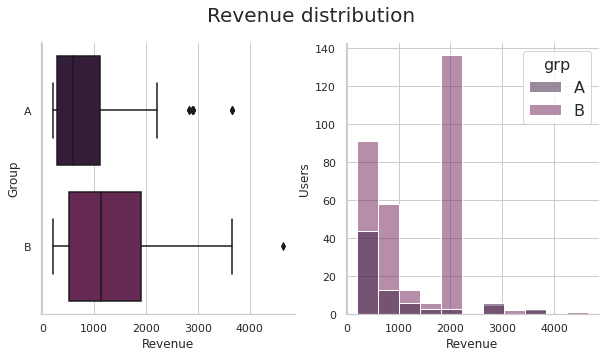

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.boxplot(data=test_results_avg, x='rev', y='grp', ax=ax1)
sns.histplot(data=test_results_avg, x='rev', hue='grp', ax=ax2)

ax1.set_xlabel('Revenue')
ax1.set_ylabel('Group')

ax2.set_xlabel('Revenue')
ax2.set_ylabel('Users')

plt.suptitle('Revenue distribution')

sns.despine()
plt.show()

Видим, что распределения несимметричны, имеют выбросы, и не унимодальны.  
Таким образом, Т-критерий не применим.  

Для применения критерия Манна-Уитни, распределение должно:
- иметь не менее 3х значений признака
- иметь мало совпадающих значений(менее 10)  
Однако, уже на этапе предобработки, мы увидели что у нас очень много(более 100) чеков с суммой ровно 1900.  
Проверим еще раз на всякий случай.

In [26]:
test_results_avg.rev.value_counts().head(5)

1900.0    128
290.0      70
199.0      32
840.0      24
990.0      22
Name: rev, dtype: int64

Таким образом U-критерий также не применим в данном случае.  
Если ни U-критерий, ни T-критерий нельзя применить, остается Бутстрап. 

Воспользуемся подготовленной функцией bootstrap из модуля bootstrap.  
В качестве статистики применим сравнение медиан, так как мы имеем значимые выбросы.

In [27]:
help(bootstrap)

Help on function bootstrap in module bootstrap:

bootstrap(data_1, data_2, boot_subsamples=1000, statistic=<function mean at 0x7f95ac1c96a8>, conf_level=0.95)
    Params:
        data_1, data_2 - samples
        boot_subsamples - bootstrap subsamples quantity
        statistic - stat, used to find differences
        conf_level - confidens level (1 - alpha)
    
    Returns:
        dict with keys:
            "boot_data": stat diff for each subsample
            "quants": quants 
            "p_value": p_value



In [28]:
# Запишем результаты контрольной и тестовой группы в соответствующие переменные
test = test_results_avg.query('grp == "B"').rev
control = test_results_avg.query('grp == "A"').rev

# Проведем бутстрап
avg_rev_stat_results = bootstrap(data_1=test,
                                 data_2=control,
                                 boot_subsamples=10000,
                                 statistic=np.mean,
                                 conf_level=0.95)

# Запишем получившийся уровень значимости в переменную
bootstrap_p_val = avg_rev_stat_results['p_value'].round(5)

# Проверим, достаточно ли у нас оснований отвергнуть нулевую гипотезу
print('Method    | p-value | Reject H0(p < 0.05)')
print(f'Bootstrap | {bootstrap_p_val} | {bootstrap_p_val < 0.05}')

Method    | p-value | Reject H0(p < 0.05)
Bootstrap | 0.00387 | True


Таким образом, у нас есть достаточно оснований, чтобы отвергнуть нулевую гипотезу.  
Значит, при введении нового механизма оплаты, мы получим статистически значимое повышение среднего чека.

***Дополнение***  
Вспомним что у нас есть веские основания полагать, что при сборе данных была допущена ошибка.  
Ориентируясь на распределение чеков по пользователям, можно предположить, что людей с чеком 1900, должно быть около 5.  
Попробуем проверить нашу гипотезу с такими вводными.

In [29]:
# Оставим 5 человек с чеком 1900
test_results_avg_corrected = pd.concat([test_results_avg.query('rev != 1900'), test_results_avg.query('rev == 1900').head(5)])

In [30]:
# Запишем результаты контрольной и тестовой группы в соответствующие переменные
test = test_results_avg_corrected.query('grp == "B"').rev
control = test_results_avg_corrected.query('grp == "A"').rev

# Проведем бутстрап
avg_rev_stat_results = bootstrap(data_1=test,
                                 data_2=control,
                                 boot_subsamples=10000,
                                 statistic=np.mean,
                                 conf_level=0.95)

# Запишем получившийся уровень значимости в переменную
bootstrap_p_val = avg_rev_stat_results['p_value'].round(5)

# Проверим, достаточно ли у нас оснований отвергнуть нулевую гипотезу
print('Method    | p-value | Reject H0(p < 0.05)')
print(f'Bootstrap | {bootstrap_p_val} | {bootstrap_p_val < 0.05}')

Method    | p-value | Reject H0(p < 0.05)
Bootstrap | 0.44556 | False


И подтвердим догадку, что если сбор данных проведен некорректно и в наши результаты попало много пользователей со средним чеком 1900, по причинам не связанным с нашей изначальной гипотезой.  
То, если их отбросить, мы уже не имеем никаких оснований отклонить нулевую гипотезу. А значит механизм оплаты не повлиял на средний чек.

### Гипотеза 2 
**Если** мы введем новую механику оплаты услуг на сайте,  
**То** мы увеличим конверсию в продажу

**В статистическом представлении:**  
H0 - никаких различий в конверсии для тестовой и контрольной группы нет.  
H1 - из-за новой механики оплаты, конверсия изменилась статистически значимо

##### Выбор статистического критерия, дляанализа результатов А/В тестирования.  
Для анализа конверсии используем χ²

In [31]:
# Оставим только необходимые данные
test_results_cr = metrics_by_group.loc[:,['total_checks', 'active_users']]

# Посчитаем критерий
stat, p, dof, expected = chi2_contingency(test_results_cr, correction=False)
p = np.round(p, 5)

# Проверим, достаточно ли у нас оснований отвергнуть нулевую гипотезу
print('Method | p-value | Reject H0(p < 0.05)')
print(f'χ²     | {p} | {p < 0.05}')

Method | p-value | Reject H0(p < 0.05)
χ²     | 0.46726 | False


Если бы целевой метрикой была конверсия, у нас бы не было никаких оснований отвергать нулевую гипотезу.

# Выводы по заданию 1. А/В тест.

Подводя итоги, можно сказать, что:
1. Есть явные признаки того, что при сборе данных была допущена ошибка  
2. Если считать что это не ошибка, то новый механизм оплаты действительно повлиял на средний чек пользователей. "Можно выкатывать".  
3. Если отбросить значения, кажущиеся ошибочными, новый механизм оплаты - не оказывает статистически значимого влияния на средний чек. "Выкатывать нет смысла".
4. Новый механизм оплаты не оказывает статистически значимого влияния на конверсию в продажу.

# Задание 2. SQL

Задание на SQL решим при помощи модуля pandahouse.  
Для начала работы пропишем параетры соединения с базой

In [32]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

### 2.1 Очень усердные ученики.


##### Условие  
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий.  
Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

##### Описание данных  

In [33]:
%%html
<!-- Передвинем таблицы налево -->
<style>table {float:left}</style> 

Таблица default.peas — **таблица с информацией о решенных студентами "горошинах"**   

| Field | Description |
| :--- | :--- |
| st_id | ID ученика |
| timest | Время решения карточки |
| correct | Правильно ли решена горошина? |
| subject | Дисциплина, в которой находится горошина |

##### Задача  
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

In [34]:
# SQL req 1
sql_request = """
  SELECT st_id, 
         SUM(correct) AS total_correct  /*Cумма правильно решенных горошин*/
    FROM default.peas
   WHERE toStartOfMonth(timest) = '2020-03-01' /*Отбор студентов по марту 2020*/
GROUP BY st_id
  HAVING total_correct >= 20  /*Условие по 20 правильным горошинам*/
"""

df = ph.read_clickhouse(sql_request, connection=connection)
df.head(5)

,st_id,total_correct


В таблице нет данных по марту, да и вообще по 2020 году. Поэтому вывод пустой.  
Диапазон дат:

In [35]:
sql_request = """
SELECT CONCAT(CONCAT('Table contain dates from ', CAST(MIN(timest) AS String)), 
              CONCAT(' to ', CAST(MAX(timest) AS String))
              ) AS time_interval
FROM default.peas
"""

df = ph.read_clickhouse(sql_request, connection=connection)
df.iloc[0, 0]

'Table contain dates from 2021-10-30 13:00:00.000 to 2021-10-31 17:29:52.000'

### 2.2 Оптимизация воронки

##### Условие
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день.  
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ.  
Команда провела эксперимент, где был протестирован новый экран оплаты.

##### Описание данных

Таблица default.studs — **таблица с принадлежностью учеников к экспериментальной группе**   

| Field | Description |
| :--- | :--- |
| st_id | ID ученика |
| test_grp | Метка ученика в данном эксперименте |

Таблица default.studs — **таблица с данными о приобретении курса**   

| Field | Description |
| :--- | :--- |
| st_id | ID ученика |
| sale_time | Время покупки |
| money | Цена, по которой приобрели данный курс |
| subject | Дисциплина, на которую приобрели полный доступ |

##### Задача
Необходимо в **одном** запросе выгрузить следующую информацию о группах пользователей:
- ARPU  
- ARPAU  
- CR в покупку 
- СR активного пользователя в покупку  
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  

ARPU считается относительно всех пользователей, попавших в группы.  
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.  
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [36]:
sql_request = """
SELECT test_grp,
    /* Average Revenue / Users */
    SUM(total_money) / COUNT(DISTINCT st_id) AS ARPU,
    
    /* Average Revenue / Active Users */
    SUM(total_money) / SUM(is_active) AS ARPAU, 
    
    /* Users made a purchase / Users */
    SUM(is_paid) / COUNT(st_id) AS CR,
    
    /* If user is active and made a purchase, than is_active + is_paid > 1 */
    COUNT(DISTINCT st_id, CASE WHEN is_active + is_paid > 1 THEN 1 ELSE NULL END) / COUNT(DISTINCT st_id) AS CR_active, 
    
     /* If user either not active on math or haven't bought math course, math_active * math_money will equal 0*/
    COUNT(DISTINCT st_id, CASE WHEN math_active * math_money > 0 THEN 1 ELSE NULL END) / COUNT(DISTINCT st_id) AS CR_math
FROM
(
    SELECT 
        p.st_id AS st_id,
        grp.test_grp AS test_grp,
        p.is_active AS is_active,
        p.math_active AS math_active,
        p.is_paid AS is_paid,
        m.total_money AS total_money,
        m.math_money AS math_money
    FROM
    (
        SELECT 
            st_id,
            IF(sum(correct) >= 10, 1, 0) AS is_active,
            IF(st_id IN 
                (
                    SELECT st_id 
                    FROM default.peas 
                    WHERE subject = 'Math' 
                    GROUP BY st_id 
                    HAVING SUM(correct) >= 2
                ), 1, 0) AS math_active,            
            IF(st_id IN (SELECT DISTINCT st_id FROM default.final_project_check), 1, 0) AS is_paid
        FROM default.peas
        GROUP BY st_id
    ) AS p
    
    JOIN
    (
        SELECT * FROM default.studs
    ) AS grp
    ON p.st_id = grp.st_id
    
    LEFT JOIN
    (
        SELECT st_id, total_money, math_money
        FROM
        (
            SELECT st_id, SUM(money) AS total_money
            FROM default.final_project_check
            GROUP BY st_id
        ) AS l
        LEFT JOIN
        (
            SELECT st_id, SUM(money) AS math_money
            FROM default.final_project_check
            WHERE subject = 'Math'
            GROUP BY st_id
        ) AS r
        ON l.st_id = r.st_id
    ) AS m
    ON p.st_id = m.st_id
)
GROUP BY test_grp

"""

df = ph.read_clickhouse(sql_request, connection=connection)
df = np.round(df, 3)
df.head(5)

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,8393.939,10492.424,0.091,0.085,0.018
1,pilot,22832.168,32326.733,0.210,0.175,0.028


# Задание 3. Python

### 3.1 Дополнительные данные  
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [37]:
def add_groups_data(current_groups_public_url='https://disk.yandex.ru/d/58Us0DWOzuWAjg', 
                    groups_addition_public_url='https://disk.yandex.ru/d/3aARY-P9pfaksg',
                    active_studs_public_url='https://disk.yandex.ru/d/prbgU-rZpiXVYg', 
                    checks_public_url='https://disk.yandex.ru/d/84hTmELphW2sqQ',
                   ):
    
    #groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
    # (А – контроль, B – целевая группа) 
    # groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
    # active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    # checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
    
    """
    Params:
        - current_groups_public_url - public url to an OLD groups ya disk file  
        - current_groups_public_url - public url to an ADDITIONAL groups ya disk file  
        - active_studs - public url to A/B test activity data
        - checks - public url to A/B test purchases data
        
    Returns:
        - groups - NEW df with ADDITIONAL groups added to an OLD groups
        - metrics_by_group - df with specific metrics(cr, average check)   
    """
    
    # Ссылки на файлы данных
    data_keys = [current_groups_public_url, groups_addition_public_url, active_studs_public_url, checks_public_url]

    # Получим список url для загрузки
    download_urls = get_data_ya_disk(data_keys)
    
    # Загрузим данные в датафреймы    
    current_groups  = pd.read_csv(download_urls[0])
    groups_addition = pd.read_csv(download_urls[1])
    active_studs    = pd.read_csv(download_urls[2])
    checks          = pd.read_csv(download_urls[3], sep=';')       
    
    # С учетом специфики инжиниринга данных(разных разделителей, на данный момент), введена доп проверка размерности данных.
    # В будущем, когда(если) данные будут единообразными, проверку можно удалить.
    if current_groups.shape[1] != groups_addition.shape[1]:
        current_groups  = pd.read_csv(download_urls[0], sep=';')         
    
    # Объединим данные о принадлежности к группе
    groups = pd.concat([current_groups, groups_addition], ignore_index=True)
    
    # Объеденим данные об эксперименте (активность и оплаты)
    checks_activity = active_studs.merge(checks, on='student_id', how='left')
    
    # Дополним данные об эксперементе, информацией о принадлежности пользователя к группе.
    test_results = checks_activity.merge(groups, how='left', left_on='student_id', right_on='id').drop(columns=['student_id'])
    
    # Построим датафрейм с выбранными метриками 
    metrics_by_group = (test_results
                    .groupby('grp', as_index=False) # Сгруппируем по группе
                    .agg(active_users=('id','nunique'), # Активные пользователи
                         total_checks=('rev', 'count'), # Кол-во оплат
                         avg_check=('rev', 'mean'))     # Средний чек
                   )
    # Дополним данные конверсией в продажу
    metrics_by_group['cr'] = np.round(metrics_by_group.total_checks / metrics_by_group.active_users, 4)
    
    # Вернем датафрейм с новыми данными о принадлежности к группам и датафрейм с пересчитанными метриками.
    return groups, metrics_by_group

In [38]:
groups, metrics = add_groups_data()

In [39]:
metrics

,grp,active_users,total_checks,avg_check,cr
0,A,1538,78,933.589744,0.0507
1,B,6803,314,1257.878992,0.0462


### 3.2 Построение графиков  
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [40]:
def metrics_viz(metrics):
    
    # Значения метрик для контрольной группы
    avg_check_A = metrics.query('grp == "A"').avg_check.values[0]    
    cr_A = metrics.query('grp == "A"').cr.values[0]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5), sharey=True)

    sns.barplot(data=metrics, x='avg_check', y='grp', ax=ax1)
    sns.barplot(data=metrics, x='cr', y='grp', ax=ax2)

    ax1.set_xlabel('Average check')
    ax1.set_ylabel('Group')       
    ax1.axvline(x=avg_check_A, ymin=0, ymax=1, color='red', linestyle='--')

    ax2.set_xlabel('Conversion rate')
    ax2.set_ylabel('')
    ax2.axvline(x=cr_A, ymin=0, ymax=1, color='red', linestyle='--')

    plt.suptitle('Metrics by group(A/B)')

    sns.despine()
    plt.show()
    
    

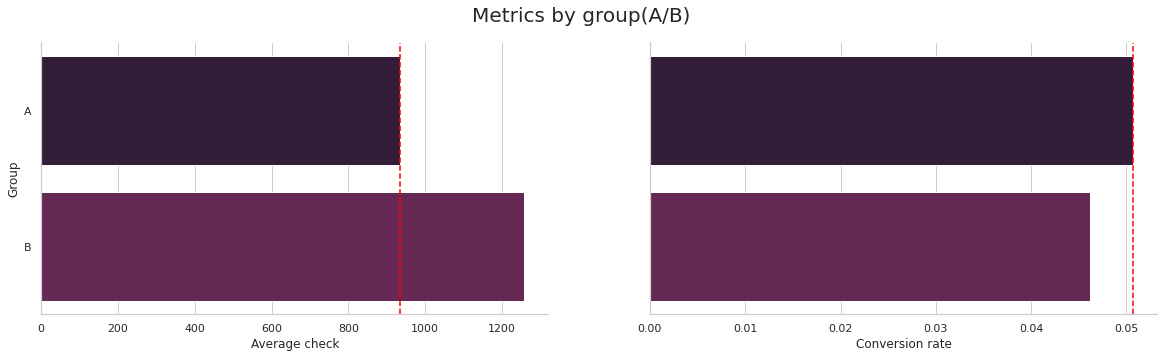

In [41]:
metrics_viz(metrics)